In [ ]:
#Select GPU in Colab Configurations
!nvidia-smi

In [ ]:
!pip install plotly q

In [ ]:
!git clone https://github.com/openai/point-e.git

In [ ]:
!pip install -e ./point-e/

In [ ]:
%cd point-e/
!pwd

In [7]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

In [9]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

Add the text description in the *prompt* variable

In [ ]:
# Load an image to condition on.
img = Image.open('../image.png')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

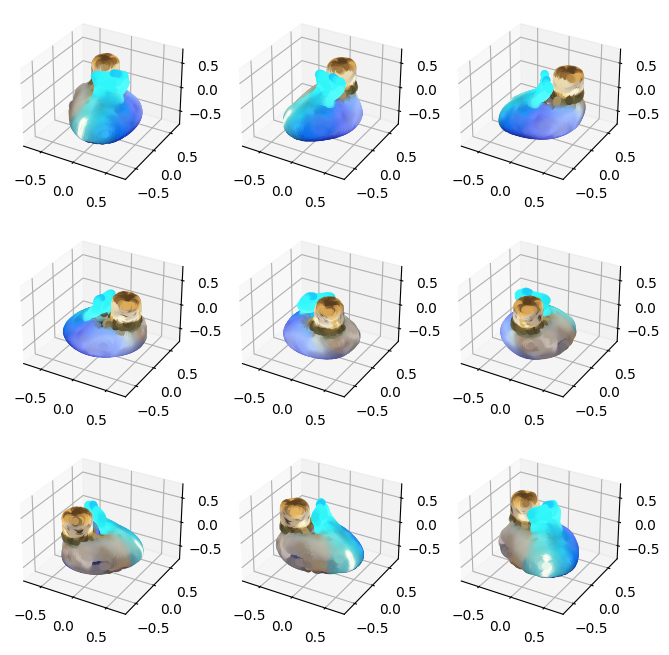

In [16]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

# The Below Code is for Visualizing 3D Point Clouds inside Google Colab

In [17]:
import plotly.graph_objects as go

In [18]:
fig_plotly = go.Figure(
  data=[
  go.Scatter3d(
    x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2],
    mode='markers',
    marker=dict(
      size=2,
      color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
    )
  )
  ],
  layout=dict(
    scene=dict(
      xaxis=dict(visible=False),
      yaxis=dict(visible=False),
      zaxis=dict (visible=False)
    )
  ),
)

In [19]:
fig_plotly.show(renderer="colab")

# The Below code is for Point Clouds to Mesh Conversion

In [20]:
#dump point cloud (pd)
import numpy as np
np.savez_compressed('PointCloudData.npz', coords=pc.coords, **pc.channels)

In [21]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

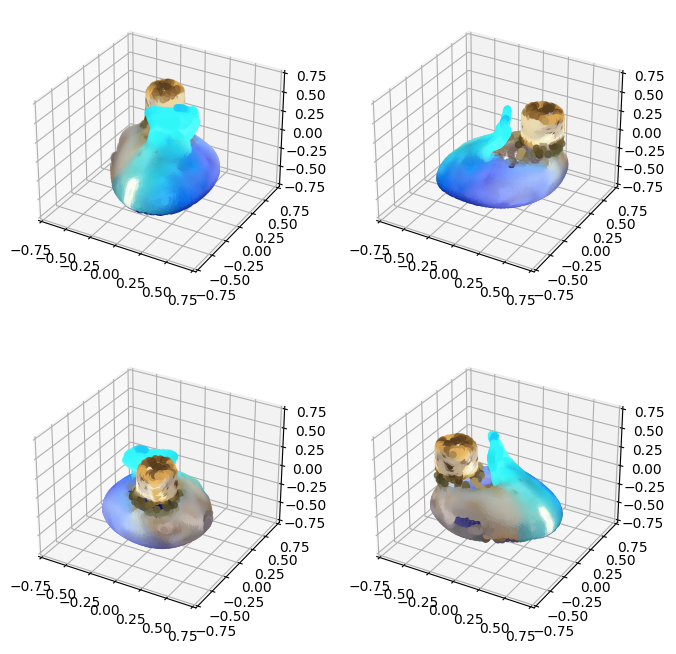

In [23]:
# Load a point cloud we want to convert into a mesh.
pc = PointCloud.load('PointCloudData.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(pc, grid_size=2)

In [ ]:
# Produce a mesh (with vertex colors)
import skimage.measure
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

You will have your Mesh data exported as 'mesh.ply' in your current directory

In [25]:
# Write the mesh to a PLY file to import into some other program.
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)